In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import lstsq
from scipy.integrate import solve_ivp
from utils import *
from utils_task3 import *

In [2]:
# loading data
data_x0 = np.loadtxt('data/nonlinear_vectorfield_data_x0.txt')
data_x1 = np.loadtxt('data/nonlinear_vectorfield_data_x1.txt')

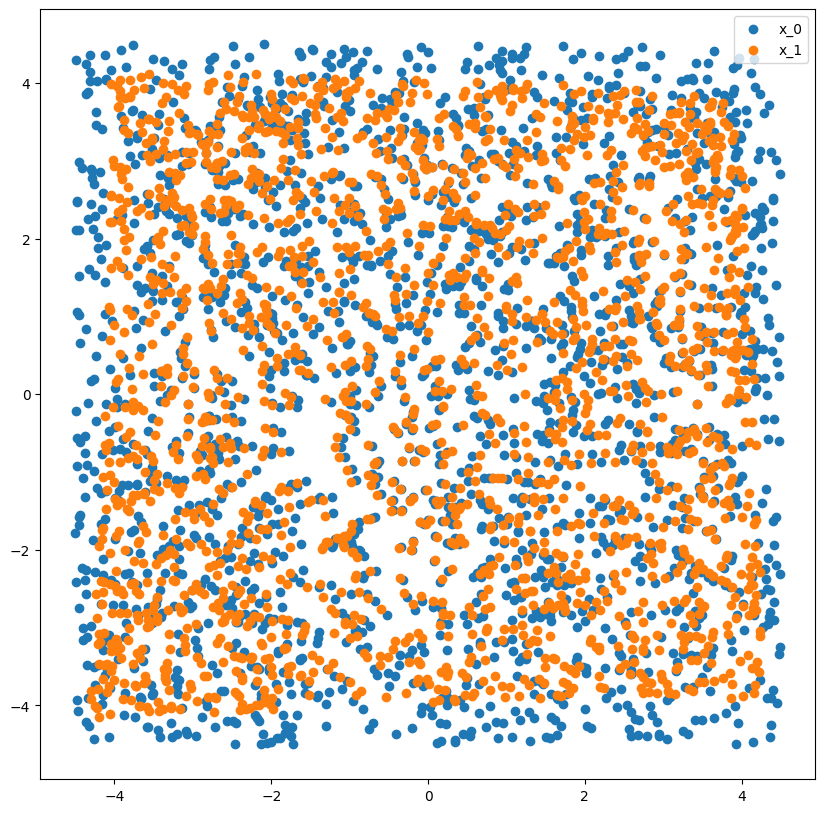

In [3]:
#plotting data
scatter_plot(data_x0, data_x1, "x_0", "x_1")

### Task 3.1

In [4]:
delta_t = 0.01
v_hat = estimate_vector(data_x0, data_x1,delta_t)
A_approximated = lstsq(data_x0, v_hat, cond=None)[0]

In [5]:
# calculate mse
predicted_x1_all = np.array([linear_approximation(A_approximated, x0, delta_t) for x0 in data_x0])
mse_all = np.mean(np.square(data_x1 - predicted_x1_all))
print(f'Mean Squared Error: {mse_all}')

Mean Squared Error: 0.0186434856287006


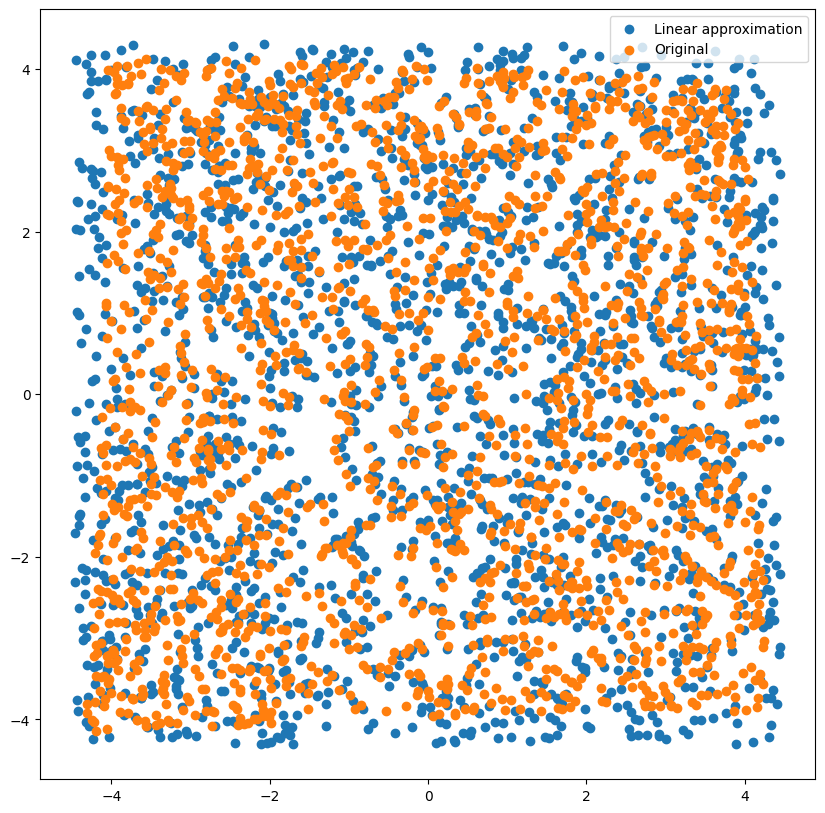

In [6]:
# plot approximated data
scatter_plot(predicted_x1_all, data_x1, "Linear approximation", "Original")

### Task 3.2

In [7]:
# find best combination of l and eps that yields lowest mse
larray = [800, 900, 1000]
epsarray = [1.5, 2, 2.5]

mse_rbf_array, mse_rbf_least, eps_least, l_least = find_optimal_rbf_setting(larray, epsarray, data_x0, v_hat)
        
print(f'Least mean Squared Error (RBF): {mse_rbf_least} reached for: l={l_least}, eps={eps_least}')

Least mean Squared Error (RBF): 2.898361613586458e-12 reached for: l=1000, eps=2


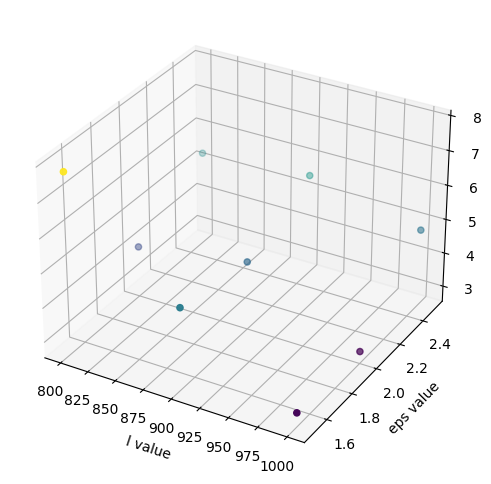

In [8]:
# comparison of l and eps values with their corresponding mse
plot_3d(mse_rbf_array)

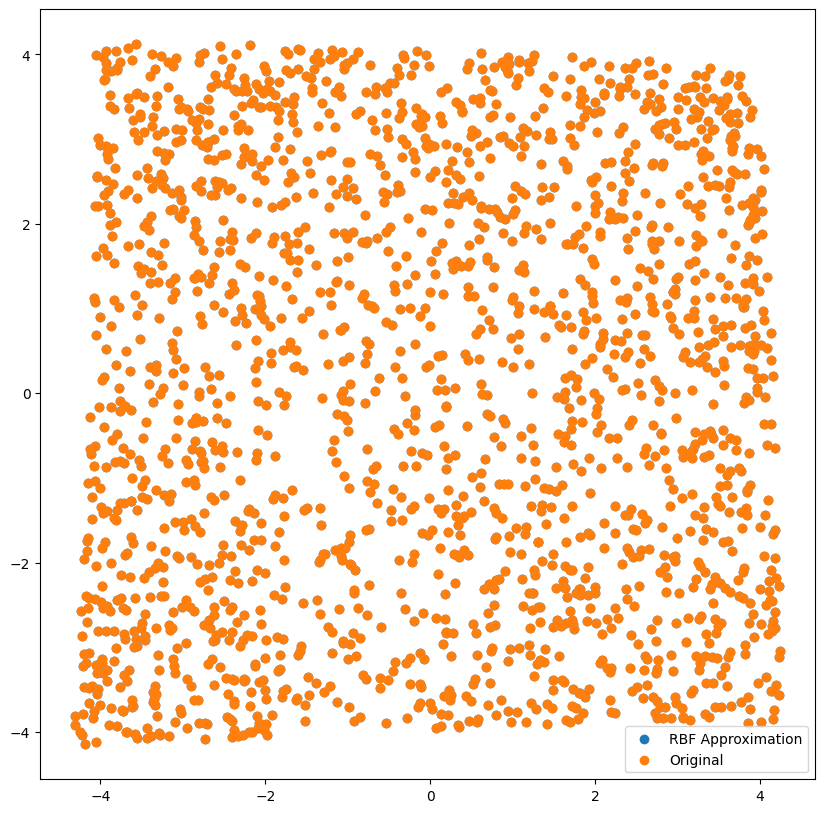

In [9]:
# Calculate approximation with optimal phi and eps
phi_optimal = radial_basis_function(data_x0, l_least, eps_least)
coefficients_optimal = lstsq(phi_optimal, v_hat, cond=None)[0]
rbf_approximated_v_x1 = np.dot(phi_optimal, coefficients_optimal)

predicted_nonlinear = nonlinear_approximation(rbf_approximated_v_x1, data_x0, delta_t)

scatter_plot(predicted_nonlinear, data_x1, "RBF Approximation", "Original")

### Task 3.3

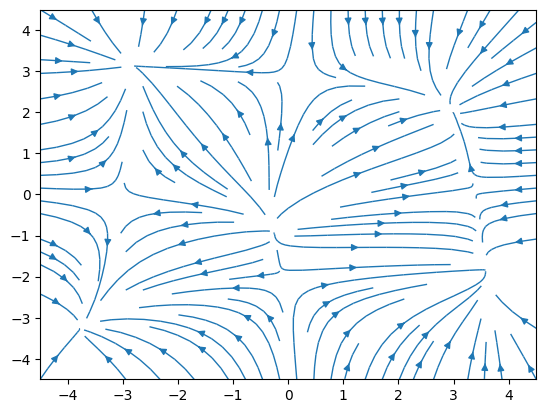

In [10]:
# plot phase portrait depicting steady states
phase_portrait(l_least, eps_least, data_x0, coefficients_optimal)